In [1]:
__author__ = "Lisette Espin"
__copyright__ = "Copyright 2021, GESIS"
__credits__ = ["Lisette Espin-Noboa", 
               "Fariba Karimi",                
               "Claudia Wagner",
               "Markus Strohmaier"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Lisette Espin"
__email__ = "lisette.espin@gesis.org"
__status__ = "Development"

In [2]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%pylab inline

import os
from org.gesis.lib import io
from org.gesis.lib import paper
from org.gesis.lib import viz

Populating the interactive namespace from numpy and matplotlib


In [4]:
ROOT = 'results/'
DATA = 'data/'

MODEL = 'DPAH'                                                     # main model
MODELS = ["Random","DPA","DH","DPAH"]                              # all models (Null)
MODELS_H = [m for m in MODELS if m not in ['Null','Random','DPA']] # models that rely on homophily
MARKERS = ["x","x","x","x"]
QTYPE = {'mae':'qae', 'me':'qe'}                                   # quadrant type (based on horizontal ineq. metric)
SMOOTH = 0.05                                                      # smooth for quadrant assignment
METRICS = ['pagerank', 'wtf']                                      # 'pagerank','wtf',indegree','outdegree',
DATASETS = ['aps','blogs','seventh','hate','wikipedia']

PLOTS = os.path.join(ROOT, 'plots')
viz.plot_setup(latex=True)                                         # Latex environment

<h2>Data</h2>

In [5]:
df_node_metadata_empirical = paper.load_node_metadata(os.path.join(ROOT,'empirical'))
df_network_metadata_empirical = paper.load_network_metadata(os.path.join(ROOT,'empirical'))
df_rank_empirical = paper.load_rank(os.path.join(ROOT,'empirical'), df_network_metadata_empirical, SMOOTH)

In [6]:
df_rank_fit = paper.load_rank_all_models(os.path.join(ROOT,'fit'), MODELS, SMOOTH)

In [7]:
df_rank = df_rank_empirical.copy()
df_rank = df_rank.append(df_rank_fit[df_rank.columns], ignore_index=True)
df_rank = df_rank.query("dataset in @DATASETS")

In [8]:
df_rank_synthetic_all = paper.load_rank_synthetic_all_models(os.path.join(ROOT,'synthetic'), MODELS, SMOOTH, False)
df_rank_synthetic = paper.remove_extra_synthetic(df_rank_synthetic_all)

print(df_rank_synthetic_all.kind.unique(), df_rank_synthetic_all.shape)
print(df_rank_synthetic.kind.unique(), df_rank_synthetic.shape)

['Random' 'DPA' 'DH' 'DPAH'] (1630537, 22)
['Random' 'DPA' 'DH' 'DPAH'] (541501, 22)


<h1>Disparity: Inequality vs. Inequity</h1>

<h2>1. Synthetic networks</h2>

In [9]:
metric = 'pagerank'
vtype = 'me'
mean = True

<h3>Global Disparity</h3>
<p>Gini Coefficient vs. MAE Fraction of minorities across top-k ranks</p>

results-batch/plots/vh_ineq_me_pagerank_mean.pdf saved!


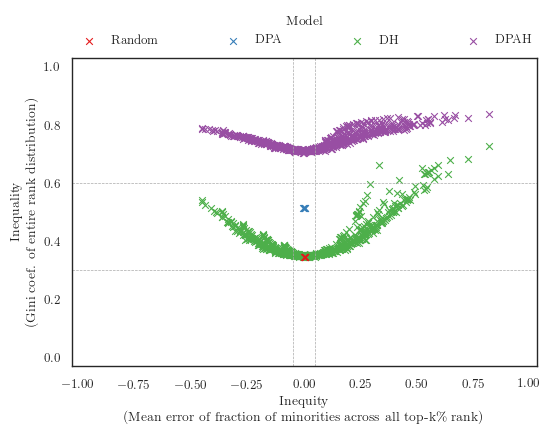

In [10]:
fn = os.path.join(PLOTS, "vh_ineq_{}_{}_{}.pdf".format(vtype, metric, 'mean' if mean else 'all'))
viz.plot_inequalities(df_rank_synthetic, MODELS, MARKERS, vtype=vtype, mean=mean, metric=metric, fn=fn)

<h3>Global Disparity as a function network structure</h3>
<p>Gini Coefficient vs. MAE Fraction of minorities in each top-k rank</p>

results-batch/plots/vh_ineq_pagerank_DPAH_qe.pdf saved!


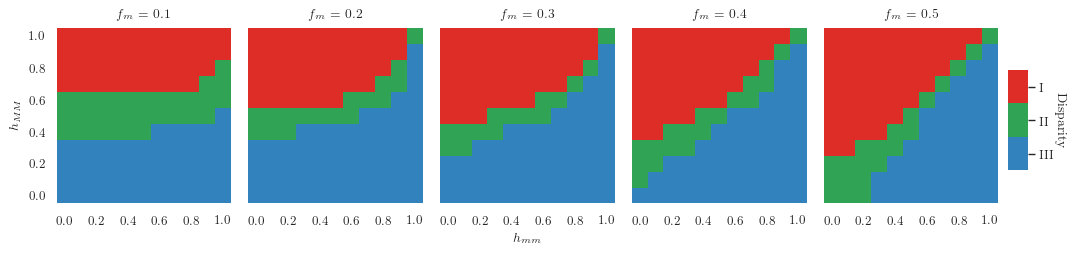

In [11]:
model = MODEL
qtype = QTYPE[vtype]
fn = os.path.join(PLOTS, "vh_ineq_{}_{}_{}.pdf".format(metric, model, qtype))
viz.plot_synthetic_quadrant_homophily(df_rank_synthetic, qtype=qtype, model=model, metric=metric, fn=fn)

<h3>Local Disparity as a function network structure</h3>
<p>Gini Coefficient vs. MAE Fraction of minorities in each top-k rank</p>

results-batch/plots/vh_ineq_topk_pagerank_DPAH_qe.pdf saved!


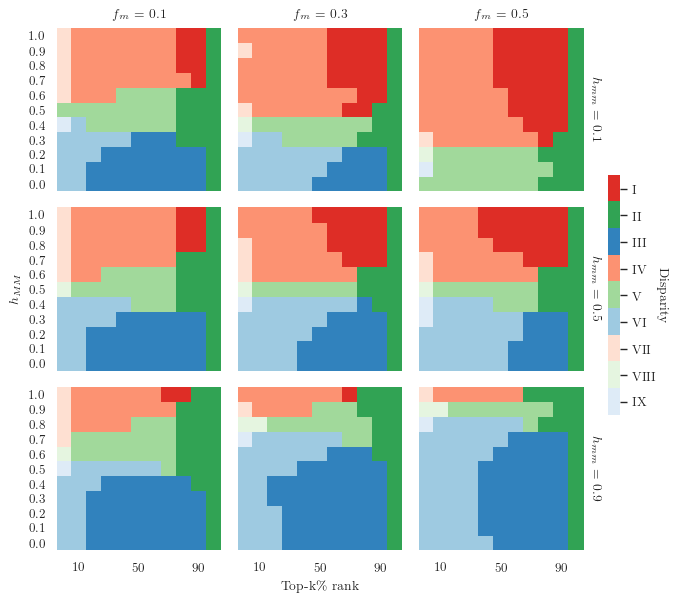

In [12]:
model = MODEL
qtype = QTYPE[vtype]
all = False
fn = os.path.join(PLOTS, "vh_ineq_topk_{}_{}_{}{}.pdf".format(metric, model, qtype, '_all' if all else ''))
viz.plot_synthetic_quadrants(df_rank_synthetic, qtype=qtype, model=model, metric=metric, all=all, fn=fn)

<h3>Correlation</h3>
<p>Spearman's test</p>

In [13]:
for local in [True,False]:
    print('Local: ' if local else 'Global: ',
          paper.spearmancor_inequality_inequity(df_rank_synthetic, model, metric, local))

Local:  SpearmanrResult(correlation=0.21465234847452905, pvalue=0.0)
Global:  SpearmanrResult(correlation=0.4111008799006741, pvalue=6.888599844888209e-250)


<h2>2. Empirical networks</h2>

results-batch/plots/vh_ineq_empirical_fit_me_pagerank_all.pdf saved!


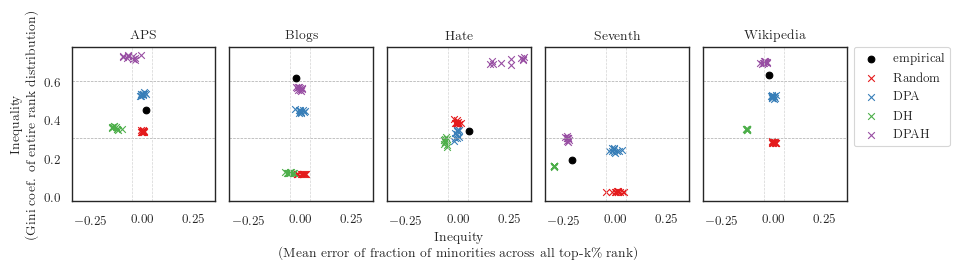

In [14]:
group = False
all = True
kind = ['empirical'] 
kind = kind + MODELS if all else kind
metrics = metric # pagerank, all, wtf

fn = os.path.join(PLOTS, "vh_ineq_empirical_fit_{}{}{}{}.pdf".format(vtype,
                                                                     "" if metrics=='all' else '_{}'.format(metrics),
                                                                   '_all' if all else '_empirical', 
                                                                   "_group" if group else ''))
viz.plot_vh_inequalities_fit(df_rank.query("kind!='SBM'"), x=vtype, group=group, kind=kind, metrics=metrics, fn=fn)


In [15]:
vtype = 'me'
df_best_fit = paper.best_fit(df_rank_fit, df_rank_empirical, datasets=DATASETS, models=MODELS, vtype=vtype)
df_best_fit.pivot_table(index='dataset', columns='metric', values='kind', aggfunc=np.unique)

metric,indegree,outdegree,pagerank,wtf
dataset,,,,
aps,DPAH,DPA,DPA,DPAH
blogs,DPAH,Random,DPAH,DPAH
hate,DPAH,DPA,DPA,DPAH
seventh,DH,DPA,DH,Random
wikipedia,DPAH,DH,DPAH,DPAH


-----